In [1]:
%load_ext autoreload
%autoreload 2

# Verify conditional circuit generation

We have previously trained a neural network known as a conditional variational autoencoder on genetic circuits. The conditioning variable was made to be one of the characteristics of the genetic circuit's dynamics, for example the sensitivity of the circuit to a signal. While the distributions for each class of conditional variables differ in the AI-generated circuits, the verification of their ground-truth label is still necessary to assess the validity of the conditionality.

## Imports

In [2]:
from synbio_morpher.srv.io.manage.script_manager import script_preamble
from synbio_morpher.srv.parameter_prediction.simulator import RawSimulationHandling, make_piecewise_stepcontrol
from synbio_morpher.utils.results.analytics.timeseries import generate_analytics
from synbio_morpher.utils.common.setup import prepare_config, expand_config, expand_model_config
from synbio_morpher.utils.data.data_format_tools.common import load_json_as_dict
from synbio_morpher.utils.results.analytics.naming import get_true_interaction_cols
from synbio_morpher.utils.results.analytics.timeseries import calculate_adaptation
from synbio_morpher.utils.misc.numerical import symmetrical_matrix_length
from synbio_morpher.utils.misc.type_handling import flatten_listlike, get_unique
from synbio_morpher.utils.modelling.deterministic import bioreaction_sim_dfx_expanded
from synbio_morpher.utils.modelling.solvers import simulate_steady_states
from bioreaction.model.data_tools import construct_model_fromnames
from bioreaction.model.data_containers import BasicModel, QuantifiedReactions
# from bioreaction.simulation.manager import simulate_steady_states
from functools import partial

from scipy.cluster.vq import whiten
from scipy.special import factorial
from sklearn.manifold import TSNE
import os
import sys
import numpy as np
import haiku as hk
import jax
import diffrax as dfx

from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import shuffle

from datetime import datetime
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

jax.config.update('jax_platform_name', 'gpu')


# if __package__ is None:

module_path = os.path.abspath(os.path.join('..'))
sys.path.append(module_path)

__package__ = os.path.basename(module_path)


np.random.seed(0)
PRNG = jax.random.PRNGKey(0)

jax.devices()

xla_bridge.py:backends():900: Unable to initialize backend 'rocm': NOT_FOUND: Could not find registered platform with name: "rocm". Available platform names are: CUDA INFO
xla_bridge.py:backends():900: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory INFO


[cuda(id=0), cuda(id=1)]

In [3]:
from evoscaper.model.vae import CVAE, sample_z, VAE_fn
from evoscaper.model.mlp import MLP
from evoscaper.model.shared import arrayise
from evoscaper.model.loss import loss_wrapper, compute_accuracy_regression, mse_loss
from evoscaper.utils.math import make_symmetrical_matrix_from_sequence_nojax
from common import init_data


## Load data

In [4]:
fn = '../data/raw/summarise_simulation/2024_11_21_144918/tabulated_mutation_info.csv'
# fn = '../data/raw/summarise_simulation/2024_11_21_160955/tabulated_mutation_info.csv'
fn_test_data = '../data/raw/summarise_simulation/2023_07_17_222747/tabulated_mutation_info.csv'
# data = pd.concat([pd.read_csv(fn), pd.read_csv(fn_test_data)])
data = pd.read_csv(fn_test_data)
len(data)

719490

## Load model

### Hyperparameters

In [5]:
# Stats
SEED = 1
PRNG = jax.random.PRNGKey(SEED)

# Architecture
HIDDEN_SIZE = 32 # 64
ENC_LS = 64
DEC_LS = 64
NUM_ENC_LAYERS = 3
NUM_DEC_LAYERS = 3
enc_layers = [ENC_LS] * NUM_ENC_LAYERS # [128, 128, 64, 64] # 
dec_layers = [DEC_LS] * NUM_DEC_LAYERS # [64, 64, 128, 128] # 

# Dataset 
OBJECTIVE_COL = 'adaptability'
include_diffs = False
input_concat_axis = 0
X_TYPE = 'energies'  # 'binding_rates_dissociation' #  
OUTPUT_SPECIES = ['RNA_1', 'RNA_2']

# Dataset training
BATCH_SIZE = 128
SCALE_X_MINMAX = True
SCALE_Y_MINMAX = True
TOTAL_DS = None
TOTAL_DS_MAX = 3e6
N_BATCHES = int(TOTAL_DS_MAX // BATCH_SIZE)
USE_X_LOGSCALE = False
USE_Y_LOGSCALE = False
USE_CATEGORICAL = False
USE_NEG_ENERGY = True

# Training
EPOCHS = 1000
LEARNING_RATE = 1e-2
LEARNING_RATE_SCHED = 'cosine_decay'  # 'constant
TRAIN_SPLIT = 0.8
USE_DROPOUT = False
USE_L2_REG = False
USE_WARMUP = True
WARMUP_EPOCHS = 20
L2_REG_ALPHA = 0.01
PRINT_EVERY = EPOCHS // 100

# Loss
loss_fn = partial(
    loss_wrapper, loss_f=mse_loss, use_l2_reg=USE_L2_REG) 
compute_accuracy = compute_accuracy_regression

# Save 
TASK = '_test'
save_path = str(datetime.now()).split(' ')[0].replace(
    '-', '_') + '__' + str(datetime.now()).split(' ')[-1].split('.')[0].replace(':', '_') + '_saves' + TASK
save_path = os.path.join('weight_saves', '01_cvae', save_path)
X_COLS = list(get_true_interaction_cols(data, X_TYPE, remove_symmetrical=True))
if include_diffs:
    X_COLS = X_COLS + \
        [[f'{i}_diffs' for i in get_true_interaction_cols(
            data, X_TYPE, remove_symmetrical=True)]]



### Init data

In [ ]:
(df, x, cond, TOTAL_DS, N_BATCHES, x_scaling, x_unscaling, y_scaling, y_unscaling) = init_data(
    data, OUTPUT_SPECIES, X_COLS, TOTAL_DS, TOTAL_DS_MAX, BATCH_SIZE, SEED,
    USE_NEG_ENERGY, USE_X_LOGSCALE, SCALE_X_MINMAX,
    OBJECTIVE_COL, USE_Y_LOGSCALE, SCALE_Y_MINMAX, USE_CATEGORICAL)

/workdir/notebooks/common.py:138: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[763.2 651.9 748.7 ... 654.5 651.8 654.5]' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  df.loc[:, 'adaptability'] = df['adaptability'].apply(


### Init model

In [ ]:
model_fn = partial(VAE_fn, enc_layers=enc_layers, dec_layers=dec_layers, decoder_head=x.shape[-1], HIDDEN_SIZE=HIDDEN_SIZE)
model_t = hk.multi_transform(model_fn)
params = model_t.init(PRNG, x, cond, deterministic=False)
encoder, decoder, model, h2mu, h2logvar, reparam = model_t.apply

/usr/local/lib/python3.11/dist-packages/haiku/_src/initializers.py:127: UserWarning: Explicitly requested dtype float64  is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  unscaled = jax.random.truncated_normal(
/usr/local/lib/python3.11/dist-packages/haiku/_src/base.py:661: UserWarning: Explicitly requested dtype float64 requested in zeros is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  param = init(shape, dtype)


In [ ]:
fn_saves = os.path.join('weight_saves', '01_cvae', '2024_11_29__10_43_59_saves_test')
saves_loaded = load_json_as_dict(fn_saves)

p = saves_loaded[str(list(saves_loaded.keys())[-1])]['params']
p = arrayise(p)
# p['vae/~/h2mu'] = p.pop('vae/~/linear')
# p['vae/~/h2logvar'] = p.pop('vae/~/linear_1')

pred_y = model(p, PRNG, x, cond)
pred_y.shape

(18816, 6)

### Sample circuits

In [ ]:
n_to_sample = 10000
cond_splits = 10
sampled_cond = np.interp(np.random.rand(
    n_to_sample//cond_splits, cond.shape[-1]), [0, 1], np.linspace(cond.min(), cond.max(), cond_splits)[0:2])[None, :]
for i in range(1, cond_splits):
    sampled_cond0 = np.interp(np.random.rand(
        n_to_sample//cond_splits, cond.shape[-1]), [0, 1], np.linspace(cond.min(), cond.max(), cond_splits+1)[i:i+2])[None, :]
    sampled_cond = np.concatenate([sampled_cond, sampled_cond0], axis=0)
mu = np.random.normal(size=(n_to_sample, HIDDEN_SIZE))
logvar = np.random.normal(size=(n_to_sample, HIDDEN_SIZE))
z = sample_z(mu=mu, logvar=logvar, key=PRNG)
z = np.concatenate([z, sampled_cond.reshape(np.prod(sampled_cond.shape[:-1]), sampled_cond.shape[-1])], axis=-1)

fake_circuits = decoder(p, PRNG, z)
# fake_circuits = np.where(fake_circuits > 0, 0, fake_circuits)
sampled_cond.shape, fake_circuits.shape

((10, 1000, 1), (10000, 6))

<Axes: ylabel='Count'>

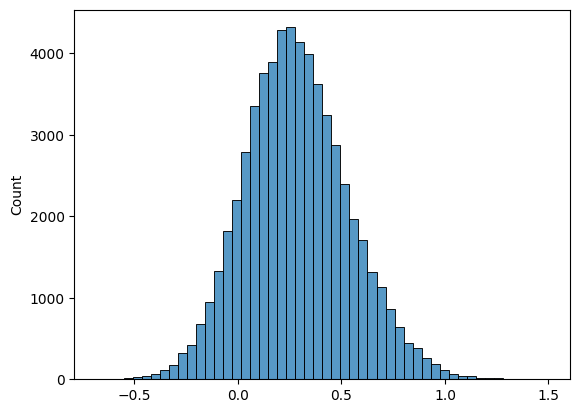

In [ ]:
# sns.histplot(decoder(p, PRNG, z).flatten(), bins=50)
sns.histplot(fake_circuits.flatten(), bins=50)

Text(0.5, 1.0, 'Sampled conditioning variable (adaptability)')

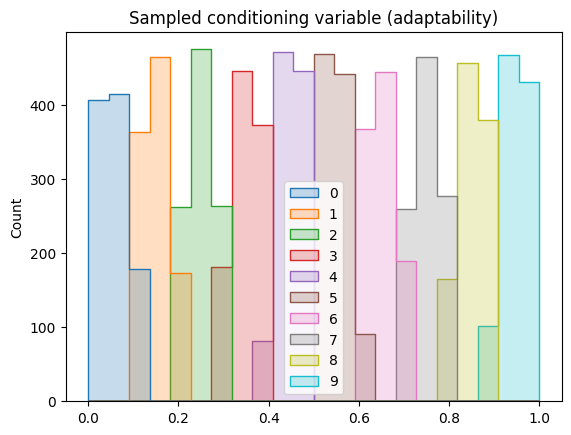

In [ ]:
sns.histplot(sampled_cond.squeeze().T, element='step')
plt.title(f'Sampled conditioning variable ({OBJECTIVE_COL})')

# Simulate 

## Construct circuits

### Config

In [ ]:
run_intarna = True

config = {
    "system_type": "RNA",
    "include_prod_deg": False,
    "data": {},
    "experiment": {
        "purpose": "tests",
        "debug_mode": False
    },
    "interaction_simulator": {
        "name": "IntaRNA",
        "postprocess": True,
        "simulator_kwargs": {
            "outcsvcols": "id1, id2, E, E_norm, bpList, hybridDPfull, seedPu1, seedPu2, seedStart1, seedStart2, seedEnd1, seedEnd2",
            "threads": 12,
            "n": 1,
            "raw_stdout": True
        }
    },
    "molecular_params_factor": 1,
    "molecular_params": {
        "avg_mRNA_per_cell": 100,
        "cell_doubling_time": 1200,
        "creation_rate": 2.35,
        "starting_copynumbers": 200,
        "degradation_rate": 0.01175,
        "association_binding_rate": 1000000
    },
    "signal": {
        "inputs": ["RNA_0"],
        "outputs": ["RNA_1"],
        "function_name": "step_function",
        "function_kwargs": {
            "impulse_center": 1, 
            "impulse_halfwidth": 5, 
            "target": 2
        }
    },
    "simulation": {
        "dt0": 0.1,
        "t0": 0,
        "t1": 100,
        "tmax": 2000,
        "solver": "diffrax",
        "use_batch_mutations": True,
        "interaction_factor": 1,
        "batch_size": 20000,
        "max_circuits": 60000,
        "device": "gpu",
        "threshold_steady_states": 0.05, 
        "use_rate_scaling": True
    },
    "system_type": "RNA",
}


if run_intarna:
    data_writer = None
    config, data_writer = script_preamble(config, data_writer)
    config = prepare_config(expand_config(config=config))

### Circuits

In [ ]:
def update_species_simulated_rates(ordered_species: list, forward_interactions, reverse_interactions, model: BasicModel, qreactions: QuantifiedReactions):
    for i, r in enumerate(model.reactions):
        if len(r.input) == 2:
            model.reactions[i].forward_rate = forward_interactions[
                ordered_species.index(r.input[0]), ordered_species.index(r.input[1])]
            
            model.reactions[i].reverse_rate = reverse_interactions[
                ordered_species.index(r.input[0]), ordered_species.index(r.input[1])]
    qreactions.reactions = qreactions.init_reactions(
        model)
    return model, qreactions

Reshape the generated circuit energies into a 3x3 symmetrical matrix.

In [ ]:
num_species = symmetrical_matrix_length(fake_circuits.shape[-1])
input_species = [f'RNA_{i}' for i in range(num_species)]
config.update(expand_model_config(config, {}, input_species))
for fn in x_unscaling:
    fake_circuits = fn(fake_circuits)


In [ ]:
# fake_circuits_reshaped = np.where(fake_circuits_reshaped > df[X_COLS[0]].max().max(), df[X_COLS[0]].max().max(), fake_circuits_reshaped)
fake_circuits = np.where(fake_circuits > df[X_COLS].max().max(), df[X_COLS].max().max(), fake_circuits)
fake_circuits_reshaped = np.array(list(map(partial(make_symmetrical_matrix_from_sequence_nojax, side_length=num_species), fake_circuits)))

In [ ]:
fake_circuits_reshaped.shape

(10000, 3, 3)

Initialise barebones circuit models

In [ ]:
model_brn = construct_model_fromnames(sample_names=input_species, include_prod_deg=config['include_prod_deg'])
ordered_species = sorted(get_unique(flatten_listlike([r.input for r in model_brn.reactions if r.output])))
signal_species = ['RNA_0']
output_species = ['RNA_1', 'RNA_2']
qreactions = QuantifiedReactions()
qreactions.init_properties(model_brn, config['starting_concentration'])
for i in range(len(model_brn.reactions)):
    model_brn.reactions[i].forward_rate = 0
    model_brn.reactions[i].reverse_rate = 0
    if (not model_brn.reactions[i].input) and config['include_prod_deg']:
        model_brn.reactions[i].forward_rate = config['molecular_params'].get(
            'creation_rate')
    elif (not model_brn.reactions[i].output) and config['include_prod_deg']:
        model_brn.reactions[i].forward_rate = config['molecular_params'].get(
            'degradation_rate')
        

reactant_species = [
    r.species for r in qreactions.reactants]
quantities = np.array([r.quantity for r in qreactions.reactants if r.species.name in input_species])
postproc = RawSimulationHandling(config['interaction_simulator']).get_postprocessing(initial=quantities)
eqconstants, (a_rates, d_rates) = postproc(np.array(fake_circuits_reshaped[0]))
model_brn, qreactions = update_species_simulated_rates(ordered_species, a_rates, d_rates, model_brn, qreactions)


/workdir/src/core-bioreaction-simulation/src/bioreaction/model/data_containers.py:230: FutureWarning: None encountered in jnp.array(); this is currently treated as NaN. In the future this will result in an error.
  forward_rates = jnp.array([r.forward_rate for r in model.reactions])
/workdir/src/core-bioreaction-simulation/src/bioreaction/model/data_containers.py:231: FutureWarning: None encountered in jnp.array(); this is currently treated as NaN. In the future this will result in an error.
  reverse_rates = jnp.array([r.reverse_rate for r in model.reactions])


## Run simulator

In [ ]:
def compute_analytics(y, t, labels, signal_onehot):
    y = np.swapaxes(y, 0, 1)

    analytics_func = partial(
        generate_analytics, time=t, labels=labels,
        signal_onehot=signal_onehot, signal_time=t[1],
        ref_circuit_data=None)
    return analytics_func(data=y, time=t, labels=labels)


def sim(y00, forward_rates, reverse_rates,
        qreactions,
        signal_onehot, signal_target,
        t0, t1, dt0, dt1,
        save_steps, max_steps):
    sim_func = jax.jit(jax.vmap(partial(bioreaction_sim_dfx_expanded,
                                t0=t0, t1=t1, dt0=dt0,
                                signal=None, signal_onehot=None,
                                inputs=qreactions.reactions.inputs,
                                outputs=qreactions.reactions.outputs,
                                forward_rates=forward_rates,
                                solver=dfx.Tsit5(),
                                saveat=dfx.SaveAt(
                                    ts=np.linspace(t0, t1, save_steps)),
                                max_steps=max_steps,
                                stepsize_controller=make_piecewise_stepcontrol(
                                    t0=t0, t1=t1, dt0=dt0, dt1=dt1)
                                )))
    """ Concentrations should be in the form [circuits, time, species] """

    y00s, ts0 = simulate_steady_states(y0=y00, total_time=t1-t0, sim_func=sim_func, t0=t0,
                                   t1=t1, threshold=0.05, reverse_rates=reverse_rates, disable_logging=True)
    y0 = np.array(y00s[:, -1, :]).reshape(y00.shape)
    print('Steady states found. Now calculating signal response')

    # Signal
    y0m = y0 * ((signal_onehot == 0) * 1) + y00 * signal_target * signal_onehot
    ys, ts = simulate_steady_states(y0m, total_time=t1-t0, sim_func=sim_func, t0=t0,
                                  t1=t1, threshold=0.05, reverse_rates=reverse_rates, disable_logging=True)
    ys = np.concatenate([y0m, ys.squeeze()[:, :-1, :]], axis=1)

    analytics = jax.vmap(partial(compute_analytics, t=ts, labels=np.arange(
        ys.shape[-1]), signal_onehot=signal_onehot))(ys)

    return analytics, ys, ts, y0m, y00s, ts0

In [ ]:
eqconstants, (forward_rates, reverse_rates) = postproc(fake_circuits_reshaped)
if 'binding_rates_dissociation' == X_TYPE:
    reverse_rates = fake_circuits_reshaped
    eqconstants = forward_rates[0, 0, 0] / reverse_rates

signal_onehot = np.where([r.species.name in signal_species for r in qreactions.reactants], 1, 0)
forward_rates, reverse_rates = np.array(list(map(lambda i: i[np.triu_indices(n=forward_rates.shape[-1])], forward_rates))), np.array(list(map(lambda i: i[np.triu_indices(n=reverse_rates.shape[-1])], reverse_rates)))
signal_target = 2
y00 = np.repeat(np.array([r.quantity for r in qreactions.reactants])[None, None, :], repeats=len(fake_circuits_reshaped), axis=0)
t0, t1, dt0, dt1 = 0, 100, 0.001, 0.0008
save_steps, max_steps = 50, 16**5

analytics, ys, ts, y0m, y00s, ts0 = sim(y00, forward_rates[0], reverse_rates,
    qreactions,
    signal_onehot, signal_target,
    t0, t1, dt0, dt1,
    save_steps, max_steps)

Steady states found. Now calculating signal response


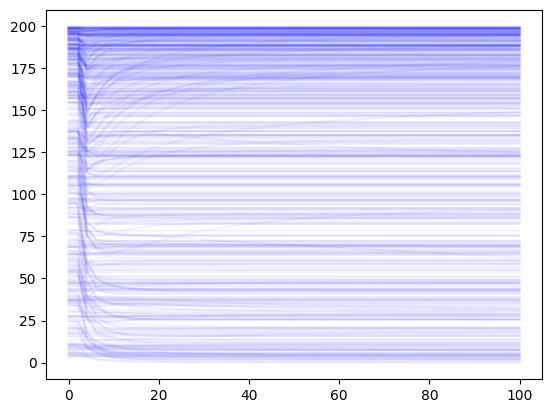

In [ ]:
plt.plot(np.repeat(ts[None, :], repeats=500, axis=0).T, ys[:500, :, -2].T, alpha=0.05, color='b')
plt.xlabel('time')

In [ ]:
print(data_writer.top_write_dir)
data_writer.output(data=analytics, out_type='json', out_name='analytics')
data_writer.output(data=ys, out_type='npy', out_name='ys')
data_writer.output(data=ts, out_type='npy', out_name='ts')
data_writer.output(data=y0m, out_type='npy', out_name='y0m')
data_writer.output(data=fake_circuits, out_type='npy', out_name='fake_circuits')

./data/tests/2024_12_02_135345


In [ ]:
analytics['sensitivity_wrt_species-6'] = np.array(analytics['sensitivity_wrt_species-6'])
analytics['precision_wrt_species-6'] = np.array(analytics['precision_wrt_species-6'])

# Visualise

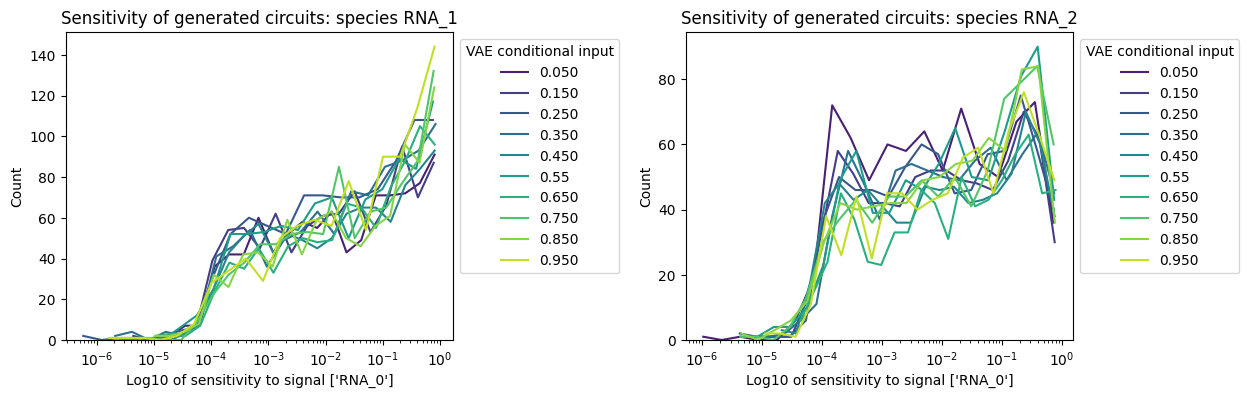

In [ ]:
fig = plt.figure(figsize=(13, 4))
fig.subplots_adjust(wspace=0.6)
for i, output_specie in enumerate(output_species):
    output_idx = [s.name for s in model_brn.species].index(output_species[i])

    s = analytics['sensitivity_wrt_species-6']
    s = np.where(s == 0, 1e-7, s)

    ax = plt.subplot(1, 2, i+1)
    pal = sns.color_palette('viridis', cond_splits)
    sample_conds_ave = np.mean(np.array([np.linspace(cond.min(), cond.max(
    ), cond_splits+1)[i:m+2] for i, m in zip(range(2), range(cond_splits-2, cond_splits+1))]), axis=0)
    for i in range(cond_splits):
        sns.histplot(analytics['sensitivity_wrt_species-6'][(i*n_to_sample//cond_splits):((i+1) *
                                                            n_to_sample//cond_splits), output_idx],  element='step', log_scale=[True, False],
                     kde=False, fill=False, color=pal[i], bins=20, label=f'{str(sample_conds_ave[i])[:5]}')
        # plt.vlines(np.percentile(analytics['sensitivity_wrt_species-6'][i*n_to_sample//cond_splits:(i+1) * n_to_sample//cond_splits,
        #            output_idx], q=50), ymin=0, ymax=170, color=sns.color_palette('viridis', n_colors=cond_splits)[i], linestyles='dashed')
    # sns.histplot(s.reshape(cond_splits, np.prod(s.shape)//cond_splits).T, element='step', log_scale=[True, False], kde=True, fill=False)
    # plt.vlines(np.percentile(analytics['sensitivity_wrt_species-6']
    #            [:n_to_sample//2, output_idx], q=[25, 50, 75]), ymin=0, ymax=350)
    # ax2 = plt.subplot(1,2,2, sharex=ax)
    # sns.histplot(analytics['sensitivity_wrt_species-6'][n_to_sample//2:,
    #              output_idx], element='step', log_scale=[True, False], kde=True)
    # plt.vlines(np.percentile(analytics['sensitivity_wrt_species-6'][n_to_sample //
    #            2:, output_idx], q=[25, 50, 75]), ymin=0, ymax=350, color='orange')
    # plt.vlines(np.power(10, sample_conds_ave), ymin=0, ymax=170, color=sns.color_palette(
    #     'viridis', n_colors=cond_splits), linestyles='dashed')

    plt.legend(title='VAE conditional input')
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
    plt.title(f'Sensitivity of generated circuits: species {output_specie}')
    plt.xlabel(f'Log10 of sensitivity to signal {signal_species}')

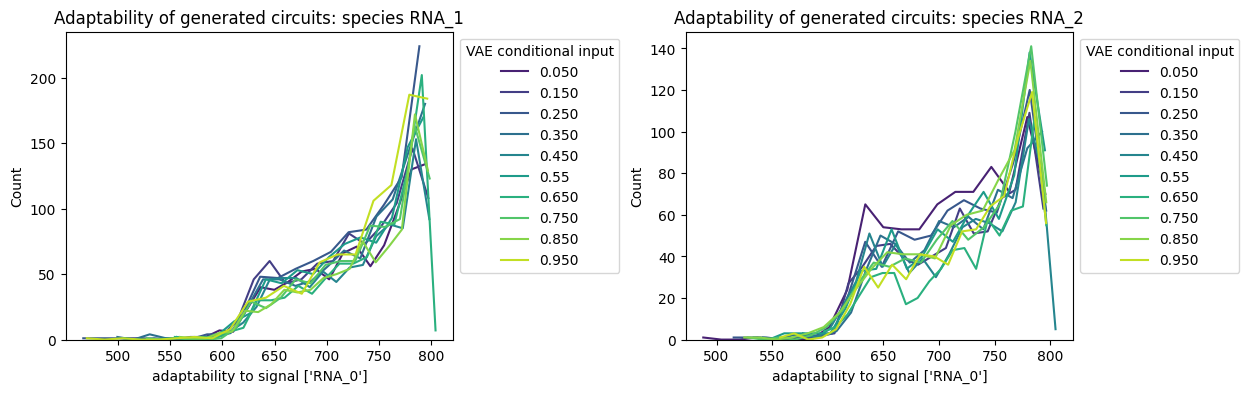

In [ ]:
fig = plt.figure(figsize=(13, 4))
fig.subplots_adjust(wspace=0.6)
analytics['adaptation'] = calculate_adaptation(
    analytics['sensitivity_wrt_species-6'], analytics['precision_wrt_species-6'])
for i, output_specie in enumerate(output_species):
    output_idx = [s.name for s in model_brn.species].index(output_species[i])
    ax = plt.subplot(1, 2, i+1)
    pal = sns.color_palette('viridis', cond_splits)
    sample_conds_ave = np.mean(np.array([np.linspace(cond.min(), cond.max(
    ), cond_splits+1)[i:m+2] for i, m in zip(range(2), range(cond_splits-2, cond_splits+1))]), axis=0)
    for i in range(cond_splits):
        sns.histplot(analytics['adaptation'][(i*n_to_sample//cond_splits):((i+1) * n_to_sample//cond_splits), output_idx], 
                     element='poly', log_scale=[False, False],
                     kde=False, fill=False, color=pal[i], bins=20, label=f'{str(sample_conds_ave[i])[:5]}')
    plt.legend(title='VAE conditional input')
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
    plt.title(
        f'{OBJECTIVE_COL.capitalize().split("_")[0]} of generated circuits: species {output_specie}')
    plt.xlabel(f'{OBJECTIVE_COL} to signal {signal_species}')

category.py:update():223: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting. INFO
category.py:update():223: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting. INFO
category.py:update():223: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting. INFO
category.py:update():223: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting. INFO


Diffs: [nan nan nan nan nan nan nan nan nan nan] nan


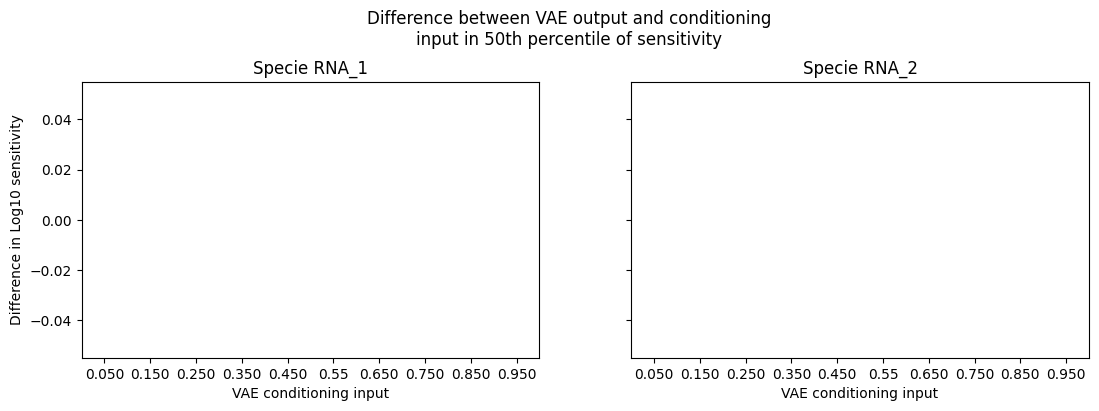

In [ ]:
# fig = plt.figure(figsize=(13, 4))
fig, axs = plt.subplots(1, 2, sharey=True, figsize=(13, 4))
fig.subplots_adjust(hspace=0.3, top=0.8)
for i, output_specie in enumerate(output_species):
    output_idx = [s.name for s in model_brn.species].index(output_species[i])

    diffs_conditional_real_sens = np.log10(np.array([np.percentile(
        analytics['sensitivity_wrt_species-6'][i*n_to_sample//cond_splits:(i+1) * n_to_sample//cond_splits, output_idx], 
        q=[25, 50, 75]) for i in range(cond_splits)])) - sample_conds_ave[:, None]

    plt.axes(axs[i])
    sns.barplot(pd.DataFrame(diffs_conditional_real_sens.T, columns=[
                str(i)[:5] for i in sample_conds_ave]), palette='viridis', ax=axs[i])
    plt.xlabel('VAE conditioning input')
    plt.ylabel('Difference in Log10 sensitivity')
    plt.title(f'Specie {output_specie}')

plt.suptitle('Difference between VAE output and conditioning\ninput in 50th percentile of sensitivity')
print('Diffs:', diffs_conditional_real_sens[:, 1], np.sum(np.abs(diffs_conditional_real_sens[:, 1])))

Text(0.5, 0.98, 'Generated circuits: sensitivity vs. precision')

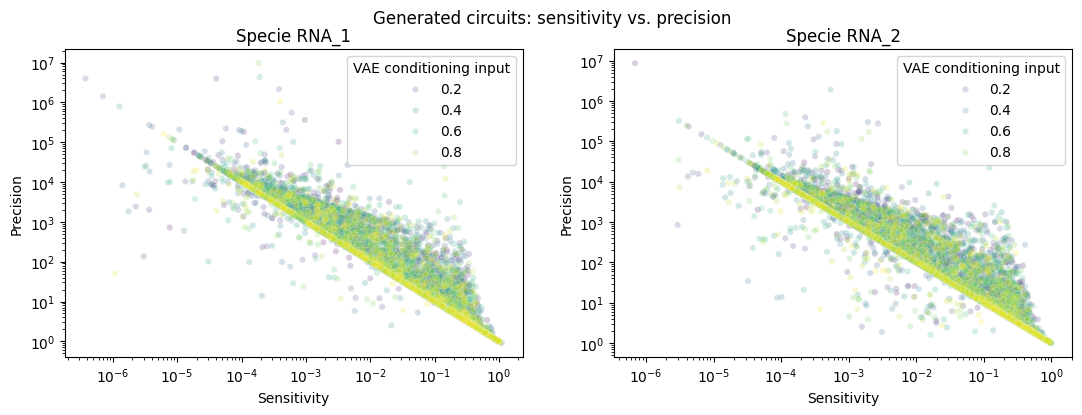

In [ ]:

# fig, axs = plt.subplots(1, 2, sharey=True, figsize=(13, 4))
fig = plt.figure(figsize=(13, 4))
# fig.subplots_adjust(hspace=0.3, top=0.8)
for i, output_specie in enumerate(output_species):
    output_idx = [s.name for s in model_brn.species].index(output_species[i])
    d = pd.DataFrame()
    d['Sensitivity'] = analytics['sensitivity_wrt_species-6'][:, output_idx]
    d['Precision'] = analytics['precision_wrt_species-6'][:, output_idx]
    d['VAE conditioning input'] = sampled_cond.flatten()
    ax = plt.subplot(1,2,i+1)
    sns.scatterplot(d, x='Sensitivity', y='Precision', alpha=0.2, hue='VAE conditioning input', palette='viridis', s=20)
    plt.xscale('log')
    plt.yscale('log')
    plt.title(f'Specie {output_specie}')
plt.suptitle('Generated circuits: sensitivity vs. precision')
# sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))